# Classificação de imagens de roupas por estampa

Versão **adaptada** do repositório [dress-pattern-recognition-using-CNN](https://github.com/aakashjhawar/dress-pattern-recognition-using-CNN), de aakashjhawar.

### Importando bibliotecas

In [1]:
from torchvision import transforms
from torchvision.transforms import Compose

from utils import *

### Criando pastas, definindo dataset e variáveis a serem utilizadas

In [6]:
IMAGE_SIZE = (64, 64)

In [7]:
# Caminhos a serem acessados

## Pasta contendo os arquivos CSV contendo a classificação original de cada imagem
csv_files_path = "csv_files"

## Pasta contendo as imagens segmentadas para treinamento
src_image_path = "preprocessed"

In [8]:
# Pastas onde serão salvas as imagens de acordo com a quantidade de classificações
dir_names = ["dataset_2", "dataset_3", "dataset_6"]

In [9]:
# Dicionário com nome dos arquivos CSV e quantidade de classes para cada um deles
filenames = {
    "2_details_categories.csv": 2,
    "3_details_categories.csv": 3,
    "6_details_categories.csv": 6
}

In [10]:
# Objeto Compose usado no treinamento
transform = Compose([
    transforms.ToTensor(),
    transforms.Resize(IMAGE_SIZE)
])

### Treinando o modelo

Instanciando o modelo utilizado (classe `CNNModel`) com a quantidade de categorias que desejamos utilizar (2, 3 ou 6).

Criação do dataset (`ImageFolder`) e separação em train ($80\%$) e test ($20\%$).

Treinamento do modelo utilizando 10 *epochs*. O modelo é salvo em um arquivo *.pth* que pode ser carregado posteriormente para ser testado.

In [11]:
# Dicionário com relação entre o modelo (CNNModel) e o arquivo no qual deverá ser salvo
models = {
    "model_2": [CNNModel(2), "model_weights_2.pth"],
    "model_3": [CNNModel(3), "model_weights_3.pth"],
    "model_6": [CNNModel(6), "model_weights_6.pth"]
}

In [12]:
# Treinamento do modelo + salvar em arquivos com extensão .pth
for file, num_categories in filenames.items():
    df = dataframe_create(csv_files_path, file, src_image_path)

    dataset_categories_create(df, f"dataset_{num_categories}")

    dataset_create(df, f"dataset_{num_categories}", src_image_path)

    train_loader, test_loader = train_model(num_categories, transform)

    models[f"model_{num_categories}"].append((train_loader, test_loader))

    print(f"Modelo para {num_categories} categorias salvo com sucesso em 'model_weights_{num_categories}.pth'!")

Modelo para 2 categorias salvo com sucesso em 'model_weights_2.pth'!
Modelo para 3 categorias salvo com sucesso em 'model_weights_3.pth'!
Modelo para 6 categorias salvo com sucesso em 'model_weights_6.pth'!


### Testando o modelo

Para cada modelo, utilizando o respectivo `test_loader`, podemos salvar os resultados da precisão em uma lista.

In [13]:
# Dicionário relacionando modelo e categorias
categories_dict = {"model_2": os.listdir("dataset_2"), "model_3": os.listdir("dataset_3"), "model_6": os.listdir("dataset_6")}

In [14]:
# Obtenção de métricas para medir a qualidade do modelo
metrics = []

for model, info in models.items():
    kwargs = {
        "model": info[0],
        "model_weights_path": info[1],
        "test_loader": info[2][1]
    }

    metrics.append(test_model_full_metrics(**kwargs))

In [28]:
# Separando as métricas do modelo para 6 classes
accuracy = metrics[2]["accuracy"]
precision = metrics[2]["precision"]
recall = metrics[2]["recall"]
f1 = metrics[2]["f1_score"]
conf_matrix = metrics[2]["confusion_matrix"]

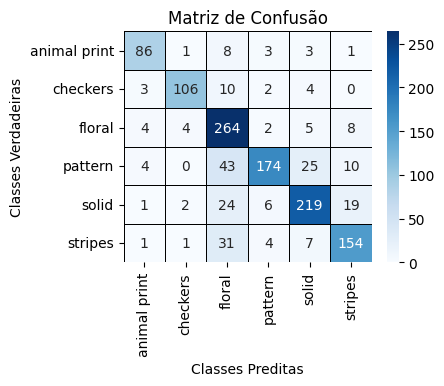

In [29]:
# Plotando o gráfico da matriz de confusão para o modelo de 6 classes
import matplotlib.pyplot as plt
import seaborn as sns

class_names = categories_dict["model_6"]

plt.figure(figsize=(4, 3))

sns.heatmap(conf_matrix,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar=True,
            linewidths=.5,
            linecolor='black'
           )

plt.xlabel('Classes Preditas')
plt.ylabel('Classes Verdadeiras')
plt.title('Matriz de Confusão')
plt.show()

### Balanceamento dos datasets

In [14]:
# Atribuindo a variáveis as quantidades de imagens para cada categoria, em cada dataset

qtde_non_solid_2 = len(os.listdir("dataset_2/non_solid"))
qtde_solid_2 = len(os.listdir("dataset_2/solid"))

qtde_geometric_3 = len(os.listdir("dataset_3/geometric"))
qtde_pattern_3 = len(os.listdir("dataset_3/pattern"))
qtde_solid_3 = len(os.listdir("dataset_3/solid"))

qtde_animal_6 = len(os.listdir("dataset_6/animal print"))
qtde_checkers_6 = len(os.listdir("dataset_6/checkers"))
qtde_floral_6 = len(os.listdir("dataset_6/floral"))
qtde_pattern_6 = len(os.listdir("dataset_6/pattern"))
qtde_solid_6 = len(os.listdir("dataset_6/solid"))
qtde_stripes_6 = len(os.listdir("dataset_6/stripes"))

total_imgs_2 = qtde_non_solid_2 + qtde_solid_2
total_imgs_3 = qtde_geometric_3 + qtde_pattern_3 + qtde_solid_3
total_imgs_6 = qtde_animal_6 + qtde_checkers_6 + qtde_floral_6 + qtde_pattern_6 + qtde_solid_6 + qtde_stripes_6

In [15]:
# Visualização da distribuição das imagens em cada dataset

print("="*60)
print("Dataset 2")

print(f"Quantidade de imagens da categoria 'non_solid': {100 * qtde_non_solid_2/total_imgs_2:.2f}%")
print(f"Quantidade de imagens da categoria 'non_solid': {100 * qtde_solid_2/total_imgs_2:.2f}%")

print("="*60)
print("Dataset 3")

print(f"Quantidade de imagens da categoria 'geometric': {100 * qtde_geometric_3/total_imgs_3:.2f}%")
print(f"Quantidade de imagens da categoria 'pattern': {100 * qtde_pattern_3/total_imgs_3:.2f}%")
print(f"Quantidade de imagens da categoria 'solid': {100 * qtde_solid_3/total_imgs_3:.2f}%")

print("="*60)
print("Dataset 6")

print(f"Quantidade de imagens da categoria 'animal print': {100 * qtde_animal_6/total_imgs_6:.2f}%")
print(f"Quantidade de imagens da categoria 'checkers': {100 * qtde_checkers_6/total_imgs_6:.2f}%")
print(f"Quantidade de imagens da categoria 'floral': {100 * qtde_floral_6/total_imgs_6:.2f}%")
print(f"Quantidade de imagens da categoria 'pattern': {100 * qtde_pattern_6/total_imgs_6:.2f}%")
print(f"Quantidade de imagens da categoria 'solid': {100 * qtde_solid_6/total_imgs_6:.2f}%")
print(f"Quantidade de imagens da categoria 'stripes': {100 * qtde_stripes_6/total_imgs_6:.2f}%")

Dataset 2
Quantidade de imagens da categoria 'non_solid': 48.55%
Quantidade de imagens da categoria 'non_solid': 51.45%
Dataset 3
Quantidade de imagens da categoria 'geometric': 37.22%
Quantidade de imagens da categoria 'pattern': 21.67%
Quantidade de imagens da categoria 'solid': 41.11%
Dataset 6
Quantidade de imagens da categoria 'animal print': 8.43%
Quantidade de imagens da categoria 'checkers': 10.22%
Quantidade de imagens da categoria 'floral': 21.95%
Quantidade de imagens da categoria 'pattern': 21.36%
Quantidade de imagens da categoria 'solid': 21.34%
Quantidade de imagens da categoria 'stripes': 16.71%


O comportamento observado para o dataset com 6 classes justifica a qualidade do modelo, isto é, a classe "animal print", por ter uma amostragem menor, deveria apresentar um número menor de classificações a partir do modelo sobre o dataset de teste.

### Salvando o modelo para JIT

In [ ]:
# Criando a pasta models
output_dir = "models"
os.makedirs(output_dir, exist_ok=True)
print(f"Verificando/criando diretório: {output_dir}")

Verificando/criando diretório: models


In [ ]:
# Garantindo que o modelo seja salvo em CPU
device = torch.device("cpu")

# Salvando o modelo em JIT (.pt) para rodar no backend da aplicação
try:
    model = models["model_3"][0].to(device)

    traced_model = torch.jit.trace(
        model,
        torch.randn(1, 3, IMAGE_SIZE[0], IMAGE_SIZE[1]).to(device)
    ).save(
        os.path.join("models", f"jit_model_detail_3.pt").lower()
    )

    print(f"Modelo TorchScript salvo em: {os.path.join(output_dir, f'jit_model_detail_3.pt').lower()}")

except Exception as e:
    print(f"Erro ao rastrear ou salvar o modelo JIT: {e}")

Modelo TorchScript salvo em: models\jit_model_detail_3.pt
